In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

import os
import warnings
warnings.simplefilter(action = 'ignore', category=FutureWarning)
warnings.filterwarnings('ignore')
def ignore_warn(*args, **kwargs):
    pass

warnings.warn = ignore_warn 

from sklearn.preprocessing import RobustScaler, PolynomialFeatures, MinMaxScaler
from sklearn.feature_selection import RFECV
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold, train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

## Load Datasets

In [2]:
# Save to csv
train_test=pd.read_csv ('./data/train_testEDA.csv')
y_test=pd.read_csv ('./data/sample_submission.csv')

y_test.drop("Id", axis = 1, inplace = True)

train_test['SalePrice'][-1459:]=y_test['SalePrice']
train_test['SalePrice']


0       208500.000000
1       181500.000000
2       223500.000000
3       140000.000000
4       250000.000000
            ...      
2912    167081.220949
2913    164788.778231
2914    219222.423400
2915    184924.279659
2916    187741.866657
Name: SalePrice, Length: 2917, dtype: float64

In [3]:
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) 
pd.set_option('max_rows', 1500)
pd.set_option('max_columns', 300)
pd.set_option('max_colwidth', 80)

sns.set(style="ticks", color_codes=True, font_scale=1.5)
color = sns.color_palette()
sns.set_style('darkgrid')

In [4]:
train_test['SalePrice'][-1459:]=y_test['SalePrice']
y=train_test['SalePrice']

## Check for any correlations between features

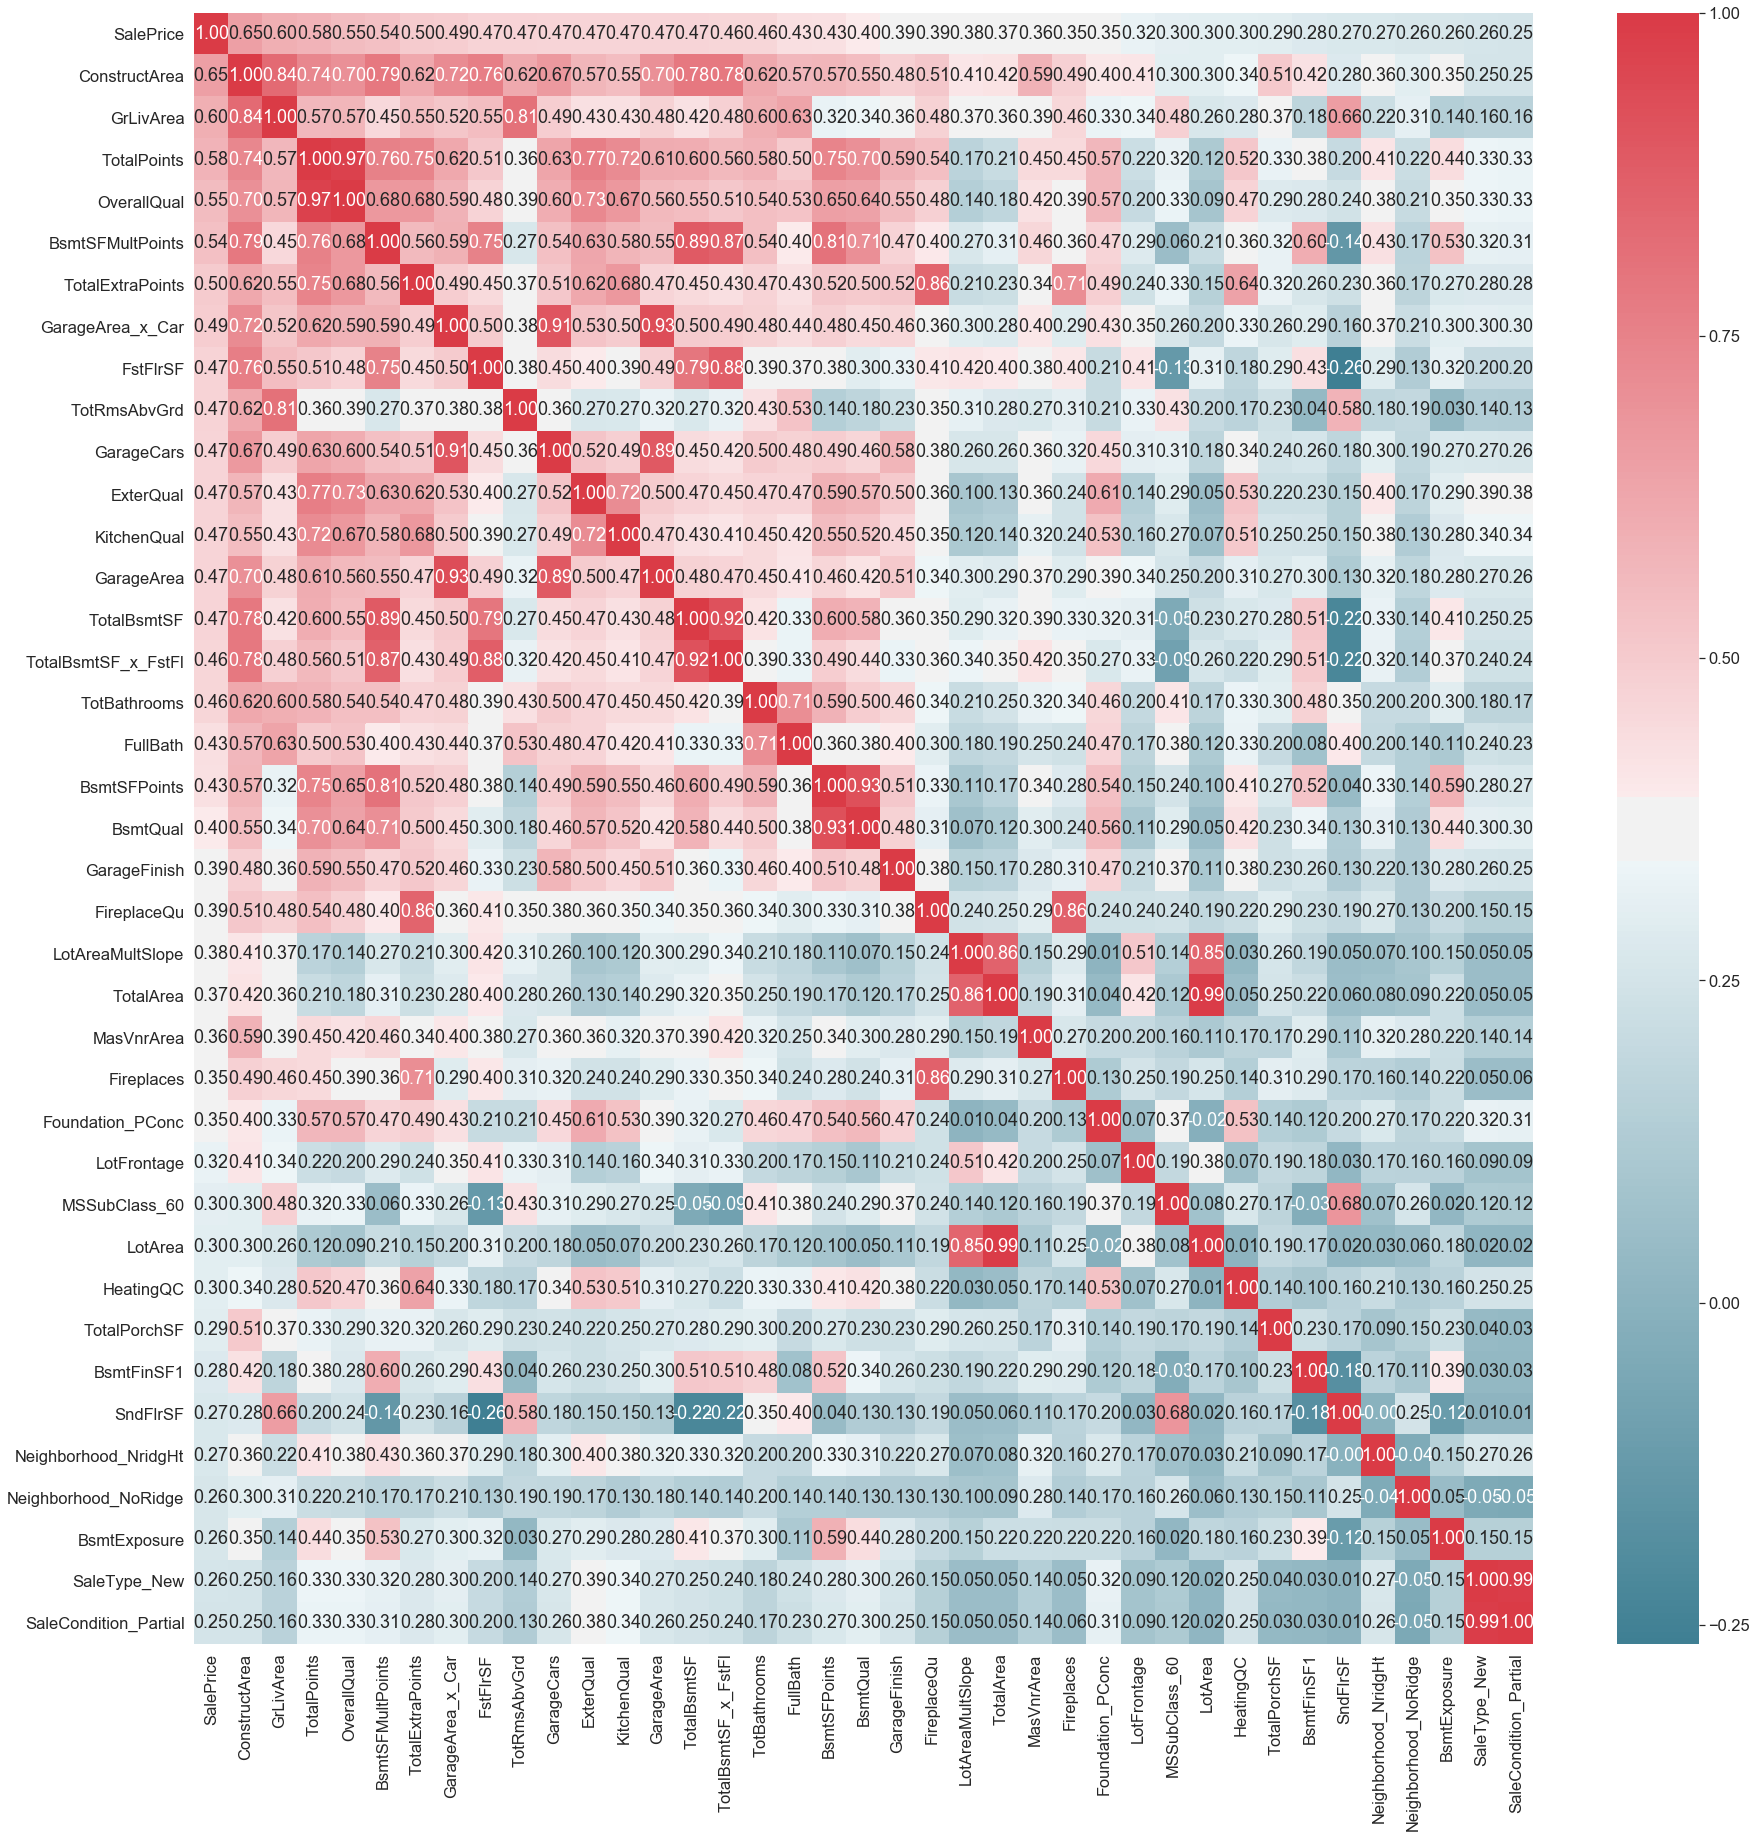

In [5]:
corr = train_test[train_test['SalePrice']>1].corr()
top_corr_cols = corr[abs((corr['SalePrice'])>=.25)]['SalePrice'].sort_values(ascending=False).keys()
top_corr = corr.loc[top_corr_cols, top_corr_cols]

plt.figure(figsize=(30, 30))
sns.heatmap(top_corr, cmap=sns.diverging_palette(220, 10, as_cmap=True), annot=True, fmt=".2f")
sns.set(font_scale=0.7)
plt.show()
del corr, top_corr

In [6]:
# Drops the features with highest correlations to other Features
train_test.drop(['GrLivArea','OverallQual','GarageArea', 'GarageCars','TotRmsAbvGrd','TotalBsmtSF', 'TotalBsmtSF_x_FstFl',
               'BsmtQual','FireplaceQu', 'Fireplaces', 'LotArea', 'SaleType_New', 'BsmtSFMultPoints','BsmtSFPoints', 'TotalArea',
               'FstFlrSF', 'PoolArea', 'SaleCondition_Partial', 'Exterior1st_VinylSd', 'Exterior2nd_CmentBd',
               'GarageCond', 'HouseStyle_2Story', 'ScreenPorch', 'LowQualFinSF', 'BsmtFinSF2', 'TSsnPorch'], 
                axis=1, inplace=True) 

In [7]:
train_test.shape

(2917, 226)

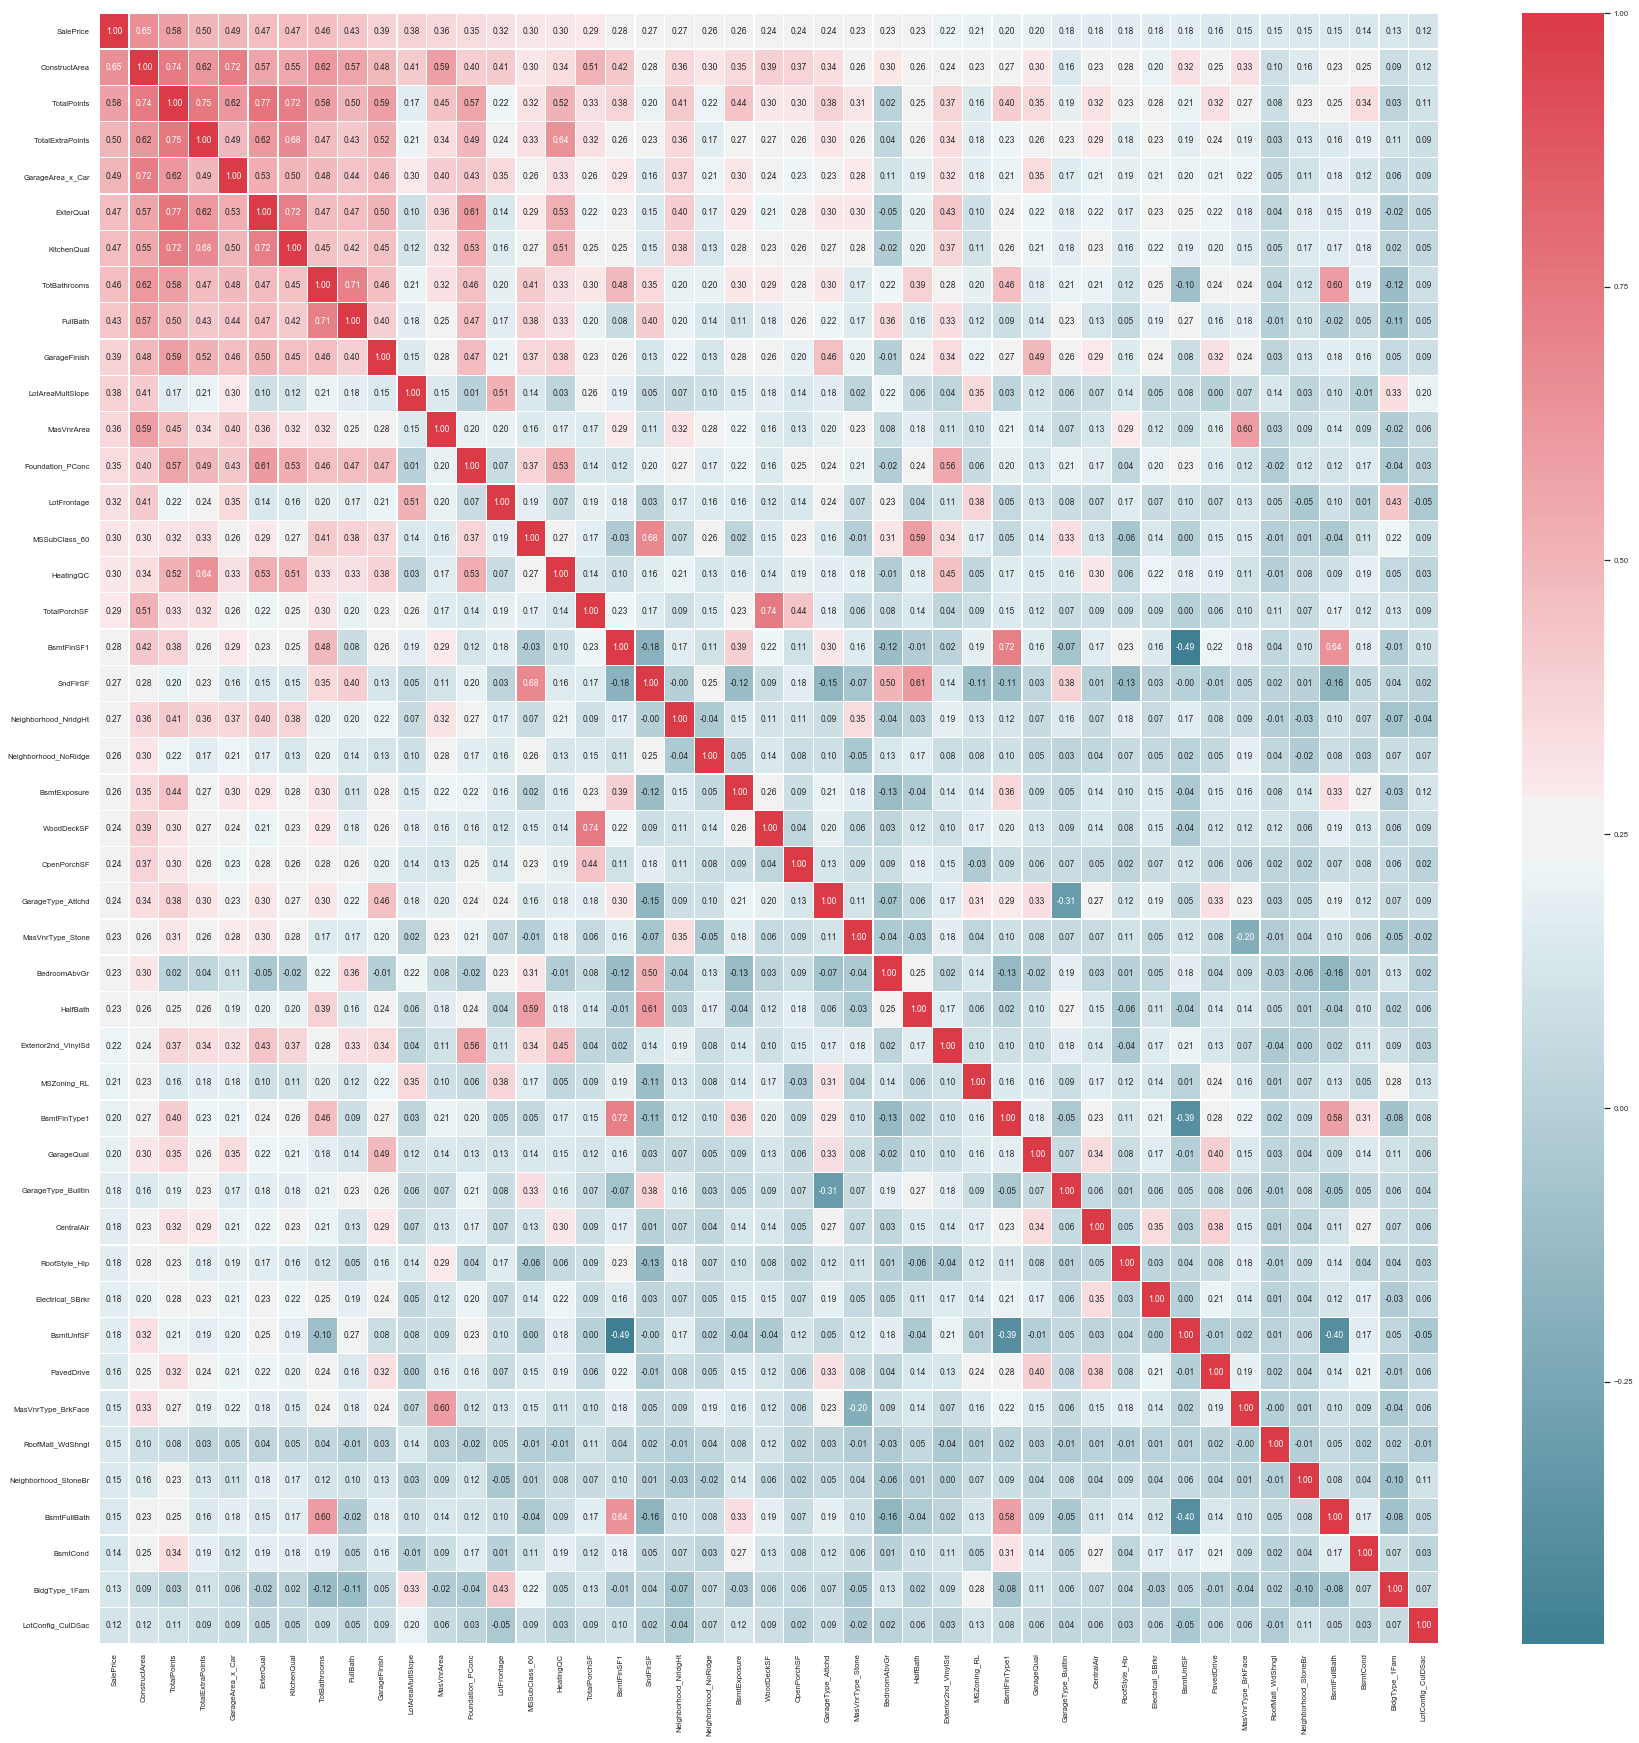

In [8]:
corr = train_test[train_test['SalePrice']>1].corr()
top_corr_cols = corr[abs((corr['SalePrice'])>=.10)]['SalePrice'].sort_values(ascending=False).keys()
top_corr = corr.loc[top_corr_cols, top_corr_cols]

plt.figure(figsize=(30, 30))
sns.heatmap(top_corr, cmap=sns.diverging_palette(220, 10, as_cmap=True), annot=True, fmt=".2f",linewidths=0.3)
sns.set(font_scale=0.7)
plt.show()
del corr, top_corr

In [9]:
#Choose only columns no SalePrice
cols = train_test.columns              #with SalePrice
cols_noSP = cols.drop(['SalePrice'])   #without SalePrice
train_test[cols].shape

(2917, 226)

In [10]:
train_test.head()

,LotFrontage,Street,LotShape,LandSlope,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtUnfSF,HeatingQC,CentralAir,SndFlrSF,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,Functional,GarageYrBlt,GarageFinish,GarageQual,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,PoolQC,Fence,MiscVal,MoSold,YrSold,SalePrice,TotalExtraPoints,TotalPoints,ConstructArea,Garage_Newest,TotalPorchSF,LotAreaMultSlope,GarageArea_x_Car,TotBathrooms,Age,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSSubClass_120,MSSubClass_150,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Alley_Grvl,Alley_NA,Alley_Pave,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,Utilities_AllPub,Utilities_NoSeWa,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Artery,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsbShng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_NA,MiscFeature_Gar2,MiscFeature_NA,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal
0,65.000,1,4,3,5,8,8,196.000,4,3,3,1,6,706.000,1,150.000,5,1,854,1.000,0.000,2,1,3,1,4,7,8.000,2,3,3,0,61,0,0,1,0,2,3,208500.000,9,91,3371.000,0,61,25350,1096.000,3.500,5,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [11]:
train_test[cols_noSP].head()

,LotFrontage,Street,LotShape,LandSlope,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtUnfSF,HeatingQC,CentralAir,SndFlrSF,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,Functional,GarageYrBlt,GarageFinish,GarageQual,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,PoolQC,Fence,MiscVal,MoSold,YrSold,TotalExtraPoints,TotalPoints,ConstructArea,Garage_Newest,TotalPorchSF,LotAreaMultSlope,GarageArea_x_Car,TotBathrooms,Age,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSSubClass_120,MSSubClass_150,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Alley_Grvl,Alley_NA,Alley_Pave,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,Utilities_AllPub,Utilities_NoSeWa,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Artery,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsbShng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_NA,MiscFeature_Gar2,MiscFeature_NA,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal
0,65.000,1,4,3,5,8,8,196.000,4,3,3,1,6,706.000,1,150.000,5,1,854,1.000,0.000,2,1,3,1,4,7,8.000,2,3,3,0,61,0,0,1,0,2,3,9,91,3371.000,0,61,25350,1096.000,3.500,5,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0

## Dependent Variable

In [12]:
# The dependent feature we want to predict is the SalePrice
y_train=train_test['SalePrice'][train_test['SalePrice']>0]
y_train.describe()

count     2917.000
mean    180058.119
std      57399.973
min      34900.000
25%     154743.916
50%     176734.841
75%     191905.870
max     755000.000
Name: SalePrice, dtype: float64

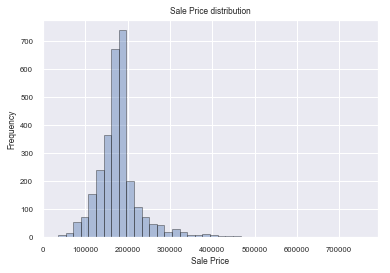

In [13]:
sns.distplot(y_train, kde = False, bins = 40, hist_kws=dict(edgecolor="k"))
plt.title('Sale Price distribution')
plt.xlabel('Sale Price')
plt.ylabel('Frequency')
plt.show()

A right-skewed distribution has a long right tail. Right-skewed distributions are also called positive-skew distributions, because there is a long tail in the positive direction on the number line. 

The mean (180.932,919) is placed to the right (i.e. higher than) of the median (163.000,000).

## Polynomials Features

In [14]:
#Create Degree 3 Polynomials Features

poly_cols = ['ConstructArea', 'TotalPoints', 'TotalExtraPoints', 'GarageArea_x_Car']

pf = PolynomialFeatures(degree=3, interaction_only=False, include_bias=False)
res = pf.fit_transform(train_test.loc[:, poly_cols])

target_feature_names = [feat.replace(' ','_')for feat in pf.get_feature_names(poly_cols)]
output_df = pd.DataFrame(res, columns = target_feature_names,  index=train_test.index).iloc[:, len(poly_cols):]
print('Polynomial Features included:', output_df.shape[1])
display(output_df.head())
train_test_PF = pd.concat([train_test, output_df], axis=1)
print('Total Features after Polynomial Features included:', train_test_PF.shape[1])
colsP = output_df.columns
cols_PF=train_test_PF.columns

del output_df, target_feature_names, res, pf

Polynomial Features included: 30


,ConstructArea^2,ConstructArea_TotalPoints,ConstructArea_TotalExtraPoints,ConstructArea_GarageArea_x_Car,TotalPoints^2,TotalPoints_TotalExtraPoints,TotalPoints_GarageArea_x_Car,TotalExtraPoints^2,TotalExtraPoints_GarageArea_x_Car,GarageArea_x_Car^2,ConstructArea^3,ConstructArea^2_TotalPoints,ConstructArea^2_TotalExtraPoints,ConstructArea^2_GarageArea_x_Car,ConstructArea_TotalPoints^2,ConstructArea_TotalPoints_TotalExtraPoints,ConstructArea_TotalPoints_GarageArea_x_Car,ConstructArea_TotalExtraPoints^2,ConstructArea_TotalExtraPoints_GarageArea_x_Car,ConstructArea_GarageArea_x_Car^2,TotalPoints^3,TotalPoints^2_TotalExtraPoints,TotalPoints^2_GarageArea_x_Car,TotalPoints_TotalExtraPoints^2,TotalPoints_TotalExtraPoints_GarageArea_x_Car,TotalPoints_GarageArea_x_Car^2,TotalExtraPoints^3,TotalExtraPoints^2_GarageArea_x_Car,TotalExtraPoints_GarageArea_x_Car^2,GarageArea_x_Car^3
0,11363641.000,306761.000,30339.000,3694616.000,8281.000,819.000,99736.000,81.000,9864.000,1201216.000,38306833811.000,1034091331.000,102272769.000,12454550536.000,27915251.000,2760849.000,336210056.000,273051.000,33251544.000,4049299136.000,753571.000,74529.000,9075976.000,7371.000,897624.000,109310656.000,729.000,88776.000,10810944.000,1316532736.000
1,10771524.000,275688.000,36102.000,3019440.000,7056.000,924.000,77280.000,121.000,10120.000,846400.000,35352141768.000,904808016.000,118486764.000,9909802080.000,23157792.000,3032568.000,253632960.000,397122.000,33213840.000,2777884800.000,592704.000,77616.000,6491520.000,10164.000,850080.000,71097600.000,1331.000,111320.000,9310400.000,778688000.000
2,12376324.000,334210.000,42216.000,4277888.000,9025.000,1140.000,115520.000,144.000,14592.000,1478656.000,43539907832.000,1175750780.000,148515888.000,15049609984.000,31749950.000,4010520.000,406399360.000,506592.000,51334656.000,5201911808.000,857375.000,108300.000,10974400.000,13680.000,1386240.000,140472320.000,1728.000,175104.000,17743872.000,1798045696.000
3,11710084.000,314824.000,41064.000,6590772.000,8464.000,1104.000,177192.000,144.000,23112.000,3709476.000,40071907448.000,1077327728.000,140521008.000,22553621784.000,28963808.000,3777888.000,606351024.000,492768.000,79089264.000,12693826872.000,778688.000,101568.000,16301664.000,13248.000,2126304.000,341271792.000,1728.000,277344.000,44513712.000,7144450776.000
4,23088025.000,533355.000,57660.000,12050940.000,12321.000,1332.000,278388.000,144.000,30096.000,6290064.000,110937960125.000,2562770775.000,277056300.000,57904766700.000,59202405.000,6400260.000,1337654340.000,691920.000,144611280.000,30223757520.000,1367631.000,147852.000,30901068.000,15984.000,3340656.000,698197104.000,1728.000,361152.000,75480768.000,15775480512.000


Total Features after Polynomial Features included: 256


In [15]:
train_test_PF[cols_PF]

,LotFrontage,Street,LotShape,LandSlope,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtUnfSF,HeatingQC,CentralAir,SndFlrSF,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,Functional,GarageYrBlt,GarageFinish,GarageQual,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,PoolQC,Fence,MiscVal,MoSold,YrSold,SalePrice,TotalExtraPoints,TotalPoints,ConstructArea,Garage_Newest,TotalPorchSF,LotAreaMultSlope,GarageArea_x_Car,TotBathrooms,Age,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSSubClass_120,MSSubClass_150,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Alley_Grvl,Alley_NA,Alley_Pave,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,Utilities_AllPub,Utilities_NoSeWa,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Artery,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsbShng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_NA,MiscFeature_Gar2,MiscFeature_NA,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,ConstructArea^2,ConstructArea_TotalPoints,ConstructArea_TotalExtraPoints,ConstructArea_GarageArea_x_Car,TotalPoints^2,TotalPoints_TotalExtraPoints,TotalPoints_GarageArea_x_Car,TotalExtraPoints^2,TotalExtraPoints_GarageArea_x_Car,GarageArea_x_Car^2,ConstructArea^3,ConstructArea^2_TotalPoints,ConstructArea^2_TotalExtraPoints,ConstructArea^2_GarageArea_x_Car,ConstructArea_TotalPoints^2,ConstructArea_TotalPoints_Total

In [16]:
y_train = (train_test_PF['SalePrice'][train_test_PF['SalePrice']>0].reset_index(drop=True, inplace=False))

# Data with Polynomials
train = train_test_PF.loc[(train_test_PF['SalePrice']>0), cols_PF].reset_index(drop=True, inplace=False)
test = train_test_PF.loc[(train_test_PF['SalePrice']==0), cols_PF].reset_index(drop=True, inplace=False)

## Select Features

In [17]:
# Preparate Data to Select Features
from sklearn.preprocessing import MinMaxScaler, RobustScaler
#scale = RobustScaler()
scale = MinMaxScaler()
# Data without Polynomials
train_test_PF = pd.DataFrame(scale.fit_transform(train_test_PF), columns= cols_PF)
train_test_PF.head()

,LotFrontage,Street,LotShape,LandSlope,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtUnfSF,HeatingQC,CentralAir,SndFlrSF,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,Functional,GarageYrBlt,GarageFinish,GarageQual,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,PoolQC,Fence,MiscVal,MoSold,YrSold,SalePrice,TotalExtraPoints,TotalPoints,ConstructArea,Garage_Newest,TotalPorchSF,LotAreaMultSlope,GarageArea_x_Car,TotBathrooms,Age,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSSubClass_120,MSSubClass_150,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Alley_Grvl,Alley_NA,Alley_Pave,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,Utilities_AllPub,Utilities_NoSeWa,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Artery,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsbShng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_NA,MiscFeature_Gar2,MiscFeature_NA,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,ConstructArea^2,ConstructArea_TotalPoints,ConstructArea_TotalExtraPoints,ConstructArea_GarageArea_x_Car,TotalPoints^2,TotalPoints_TotalExtraPoints,TotalPoints_GarageArea_x_Car,TotalExtraPoints^2,TotalExtraPoints_GarageArea_x_Car,GarageArea_x_Car^2,ConstructArea^3,ConstructArea^2_TotalPoints,ConstructArea^2_TotalExtraPoints,ConstructArea^2_GarageArea_x_Car,ConstructArea_TotalPoints^2,ConstructArea_TotalPoints_Total

In [18]:
y_train=train_test_PF['SalePrice'][:1458]
y_train

0      0.241
1      0.204
2      0.262
3      0.146
4      0.299
5      0.150
6      0.378
7      0.229
8      0.132
9      0.115
10     0.131
11     0.431
12     0.152
13     0.340
14     0.170
15     0.135
16     0.158
17     0.077
18     0.172
19     0.145
20     0.403
21     0.145
22     0.271
23     0.132
24     0.165
25     0.307
26     0.139
27     0.376
28     0.240
29     0.047
30     0.007
31     0.159
32     0.201
33     0.181
34     0.337
35     0.381
36     0.153
37     0.164
38     0.103
39     0.065
40     0.174
41     0.188
42     0.152
43     0.132
44     0.147
45     0.396
46     0.284
47     0.298
48     0.108
49     0.128
50     0.197
51     0.111
52     0.104
53     0.486
54     0.132
55     0.202
56     0.191
57     0.224
58     0.561
59     0.125
60     0.171
61     0.092
62     0.233
63     0.146
64     0.256
65     0.392
66     0.201
67     0.265
68     0.063
69     0.264
70     0.290
71     0.131
72     0.208
73     0.153
74     0.101
75     0.078
76     0.140

In [19]:
cols_PF = cols_PF.drop(['SalePrice'])
train=train_test_PF[cols_PF][:1458]
train.head()

,LotFrontage,Street,LotShape,LandSlope,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtUnfSF,HeatingQC,CentralAir,SndFlrSF,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,Functional,GarageYrBlt,GarageFinish,GarageQual,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,PoolQC,Fence,MiscVal,MoSold,YrSold,TotalExtraPoints,TotalPoints,ConstructArea,Garage_Newest,TotalPorchSF,LotAreaMultSlope,GarageArea_x_Car,TotBathrooms,Age,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSSubClass_120,MSSubClass_150,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Alley_Grvl,Alley_NA,Alley_Pave,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,Utilities_AllPub,Utilities_NoSeWa,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Artery,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsbShng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_NA,MiscFeature_Gar2,MiscFeature_NA,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,ConstructArea^2,ConstructArea_TotalPoints,ConstructArea_TotalExtraPoints,ConstructArea_GarageArea_x_Car,TotalPoints^2,TotalPoints_TotalExtraPoints,TotalPoints_GarageArea_x_Car,TotalExtraPoints^2,TotalExtraPoints_GarageArea_x_Car,GarageArea_x_Car^2,ConstructArea^3,ConstructArea^2_TotalPoints,ConstructArea^2_TotalExtraPoints,ConstructArea^2_GarageArea_x_Car,ConstructArea_TotalPoints^2,ConstructArea_TotalPoints_TotalExtraPoint

In [20]:
#Select Features by Recursive Feature Elimination
ls = Lasso(alpha = 0.0005, max_iter = 161, selection = 'cyclic', tol = 0.002, random_state = 101)
rfecv = RFECV(estimator=ls, n_jobs = -1, step=1, scoring = 'neg_mean_squared_error' ,cv=5)
rfecv.fit(train, y_train)

select_features_rfecv = rfecv.get_support()
RFEcv = cols_PF[select_features_rfecv]
print('{:d} Features Select by RFEcv:\n{:}'.format(rfecv.n_features_, RFEcv.values))

37 Features Select by RFEcv:
['LotShape' 'OverallCond' 'YearBuilt' 'YearRemodAdd' 'BsmtExposure'
 'BsmtFinSF1' 'CentralAir' 'SndFlrSF' 'KitchenQual' 'GarageFinish'
 'ConstructArea' 'LotAreaMultSlope' 'TotBathrooms' 'MSSubClass_20'
 'MSSubClass_60' 'MSZoning_RL' 'MSZoning_RM' 'LotConfig_CulDSac'
 'Neighborhood_Crawfor' 'Neighborhood_NoRidge' 'Neighborhood_NridgHt'
 'Neighborhood_OldTown' 'Neighborhood_StoneBr' 'Condition1_Norm'
 'BldgType_1Fam' 'RoofStyle_Gable' 'Exterior1st_BrkFace'
 'MasVnrType_Stone' 'Foundation_PConc' 'SaleType_WD'
 'SaleCondition_Abnorml' 'ConstructArea_TotalPoints'
 'ConstructArea_TotalExtraPoints' 'TotalPoints_GarageArea_x_Car'
 'ConstructArea_TotalPoints_TotalExtraPoints'
 'ConstructArea_TotalExtraPoints^2' 'TotalPoints^3']


In [21]:
X=train_test_PF[RFEcv]
X.head()

,LotShape,OverallCond,YearBuilt,YearRemodAdd,BsmtExposure,BsmtFinSF1,CentralAir,SndFlrSF,KitchenQual,GarageFinish,ConstructArea,LotAreaMultSlope,TotBathrooms,MSSubClass_20,MSSubClass_60,MSZoning_RL,MSZoning_RM,LotConfig_CulDSac,Neighborhood_Crawfor,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_StoneBr,Condition1_Norm,BldgType_1Fam,RoofStyle_Gable,Exterior1st_BrkFace,MasVnrType_Stone,Foundation_PConc,SaleType_WD,SaleCondition_Abnorml,ConstructArea_TotalPoints,ConstructArea_TotalExtraPoints,TotalPoints_GarageArea_x_Car,ConstructArea_TotalPoints_TotalExtraPoints,ConstructArea_TotalExtraPoints^2,TotalPoints^3
0,1.000,0.500,0.051,0.117,0.250,0.176,1.000,0.414,0.667,0.667,0.229,0.101,0.417,0.000,1.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,1.000,1.000,0.000,0.000,1.000,1.000,0.000,0.147,0.153,0.142,0.095,0.098,0.194
1,1.000,0.875,0.246,0.567,1.000,0.244,1.000,0.000,0.333,0.667,0.222,0.118,0.250,1.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,1.000,0.000,0.000,0.000,1.000,0.000,0.132,0.184,0.110,0.104,0.143,0.153
2,0.667,0.500,0.065,0.133,0.500,0.121,1.000,0.419,0.667,0.667,0.240,0.141,0.417,0.000,1.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,1.000,1.000,0.000,0.000,1.000,1.000,0.000,0.160,0.216,0.164,0.138,0.183,0.221
3,0.667,0.500,0.688,0.667,0.250,0.054,1.000,0.366,0.667,0.333,0.233,0.117,0.167,0.000,0.000,1.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,1.000,1.000,1.000,0.000,0.000,0.000,1.000,1.000,0.151,0.210,0.252,0.130,0.178,0.201
4,0.667,0.500,0.072,0.167,0.750,0.163,1.000,0.510,0.667,0.667,0.337,0.184,0.417,0.000,1.000,1.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,1.000,1.000,1.000,0.000,0.000,1.000,1.000,0.000,0.257,0.298,0.396,0.221,0.250,0.353


In [22]:
y=train_test_PF['SalePrice']
y

0      0.241
1      0.204
2      0.262
3      0.146
4      0.299
        ... 
2912   0.184
2913   0.180
2914   0.256
2915   0.208
2916   0.212
Name: SalePrice, Length: 2917, dtype: float64

## Principal Component Analysis

In [23]:
# Compressing Data via Dimensionality Reduction

In [24]:
from sklearn.decomposition import PCA

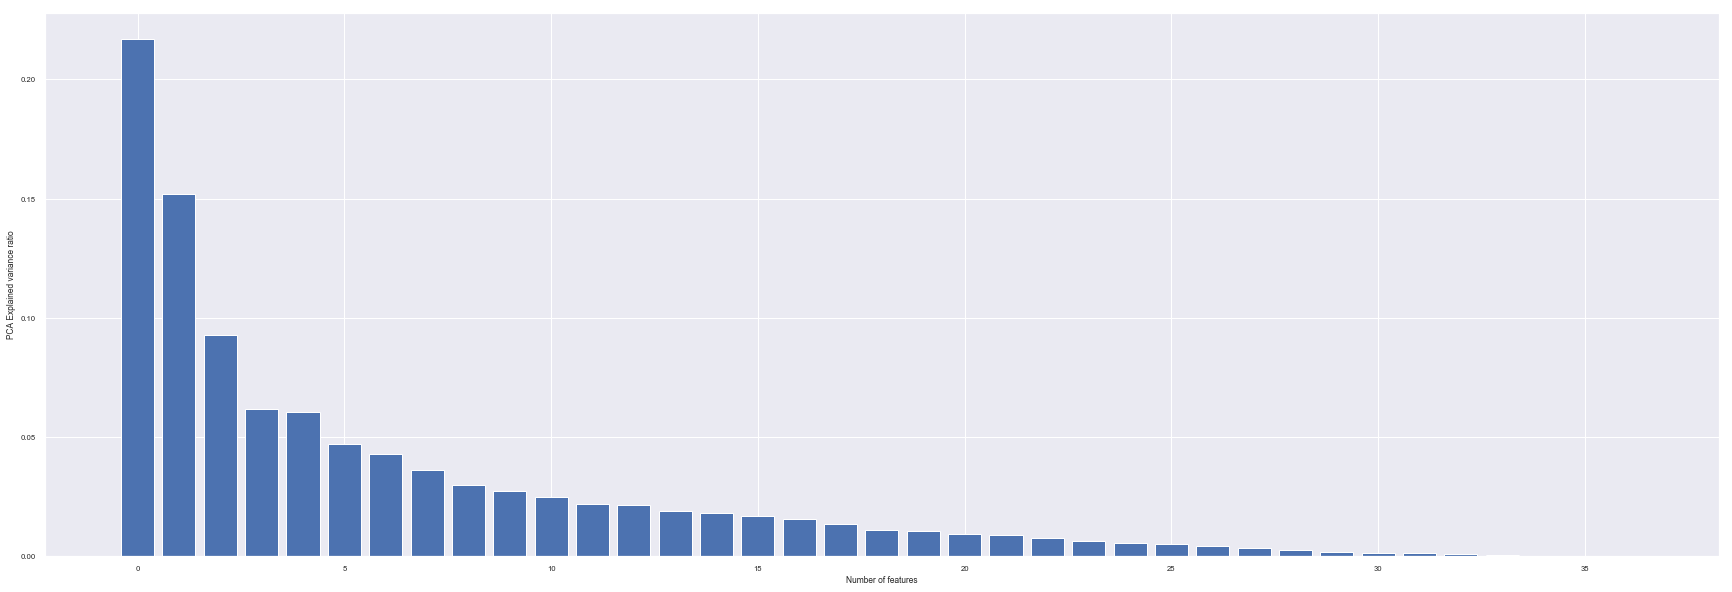

With only 30 features: 99.5936% %

After PCA,  30 features only not explained 0.4064% of variance ratio from the original 226


In [25]:
# Number of PCA components
# PCA

pca = PCA().fit(X) # whiten=True

#--------
fig = plt.figure(figsize=(30,10))
ran = range(pca.n_components_)
plt.bar(ran, pca.explained_variance_ratio_)

plt.xlabel('Number of features')
plt.ylabel('PCA Explained variance ratio')
plt.show()
#--------

print('With only 30 features: {:6.4%}'.format(sum(pca.explained_variance_ratio_[:30])),"%\n")

print('After PCA, {:3} features only not explained {:6.4%} of variance ratio from the original {:3}'.format(30,
                                                                                    (sum(pca.explained_variance_ratio_[30:])),
                                                                                    train_test.shape[1]))


In [26]:
# Split into train and test
from sklearn.model_selection import train_test_split

In [27]:
print('The original dataset (before splitting) has %d rows' %X.shape[0])

The original dataset (before splitting) has 2917 rows


In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state = 42)

In [29]:
print('We will train our models with %d ' %X_train.shape[0])

We will train our models with 2187 


## Modeling

## Mean Model

In [30]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
pred_mean = y_train.mean()
pred_mean

0.20157902278741846

In [31]:
dfr=pd.DataFrame()
dfr['y_real'] = y_train
dfr['y_pred1'] = pred_mean

In [32]:
dfr['y_pred1']

857    0.202
2703   0.202
1451   0.202
1538   0.202
1980   0.202
        ... 
1638   0.202
1095   0.202
1130   0.202
1294   0.202
860    0.202
Name: y_pred1, Length: 2187, dtype: float64

In [33]:
pred_chunk = dfr['y_pred1'][:y_test.shape[0]]

In [34]:
pred_chunk.shape, y_test.shape

((730,), (730,))

In [35]:
mae_mean = mean_absolute_error(y_test,pred_chunk)
print('Mean model: MAE = %.5f' %mae_mean)

Mean model: MAE = 0.04512


In [36]:
rmse_mean = np.sqrt(mean_squared_error(y_test,pred_chunk))
print('Mean model: RMSE = %.5f' %rmse_mean)

Mean model: RMSE = 0.07116


## Linear Regression

In [37]:
# Linear regression is the benchmark in a regression problem

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

reglin = LinearRegression()

reglin.fit(X_train, y_train)

y_pred_reglin = reglin.predict(X_test)                                                                  

In [38]:
# Mean Absolute Error
mae_reglin = mean_absolute_error(y_test,y_pred_reglin) 
print('Linear regression model: MAE = %.5f' %mae_reglin)
# Mean Squared Error
rmse_reglin = np.sqrt(mean_squared_error(y_test,y_pred_reglin)) 
print('Linear model: RMSE = %.5f' %rmse_reglin)                                                                    
# R2 score                                                                     
r2_reglin = r2_score(y_test, y_pred_reglin)
print('Linear model: R2 score = %.5f' %r2_reglin) 

Linear regression model: MAE = 0.03930
Linear model: RMSE = 0.05464
Linear model: R2 score = 0.41046


In [39]:
metrics = {'Metric': ['MAE', 'RMSE', 'R2_score'], 
           'Linear regression': [mae_reglin, rmse_reglin,r2_reglin]}
df_metrics = pd.DataFrame(data=metrics)
df_metrics

,Metric,Linear regression
0,MAE,0.039
1,RMSE,0.055
2,R2_score,0.410


In [40]:
# Feature importance
reglin_feature_list = pd.DataFrame(list(zip(X_train.columns,np.abs(reglin.coef_))), columns = ['Feature','Importance'])
reglin_feature_list.sort_values(by='Importance', ascending = False).reset_index(drop=True)

,Feature,Importance
0,ConstructArea_TotalExtraPoints,0.771
1,ConstructArea_TotalPoints_TotalExtraPoints,0.561
2,ConstructArea,0.529
3,ConstructArea_TotalExtraPoints^2,0.369
4,ConstructArea_TotalPoints,0.282
5,LotAreaMultSlope,0.228
6,SndFlrSF,0.064
7,TotalPoints^3,0.056
8,OverallCond,0.053
9,Neighborhood_NoRidge,0.044


## Ridge regularization

In [41]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

In [42]:
ridge = GridSearchCV(Ridge(),param_grid={"alpha": (0.0001,0.001,0.01,0.1,1)},cv = 5, scoring = 'neg_mean_squared_error')
ridge.fit(X_train,y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'alpha': (0.0001, 0.001, 0.01, 0.1, 1)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [43]:
ridge.best_estimator_

Ridge(alpha=1, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [44]:
ridge_be = ridge.best_estimator_

mae_ridge = mean_absolute_error(y_test,ridge_be.predict(X_test))
rmse_ridge = np.sqrt(mean_squared_error(y_test,ridge_be.predict(X_test)))
r2_ridge = r2_score(y_test, ridge_be.predict(X_test))

print('Ridge model: MAE = %.5f' %mae_ridge)
print('Ridge model: RMSE = %.5f' %rmse_ridge)
print('Ridge model: R2 score = %.5f' %r2_ridge)

df_metrics['Ridge regression']= pd.Series([mae_ridge, rmse_ridge, r2_ridge])
df_metrics

Ridge model: MAE = 0.03910
Ridge model: RMSE = 0.05337
Ridge model: R2 score = 0.43758


,Metric,Linear regression,Ridge regression
0,MAE,0.039,0.039
1,RMSE,0.055,0.053
2,R2_score,0.410,0.438


## Elastic Net

In [45]:
from sklearn.linear_model import ElasticNet

elnet= GridSearchCV(ElasticNet(), param_grid={
                      'alpha': [0.0001,0.001, 0.01, 0.1, 1],
                      'l1_ratio': [0, 0.25, 0.5, 0.75, 1]}, 
                  cv =5, scoring='neg_mean_squared_error')

elnet.fit(X_train, y_train) 

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 1], 'l1_ratio': [0, 0.25, 0.5, 0.75, 1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [46]:
elnet.best_estimator_

ElasticNet(alpha=0.001, copy_X=True, fit_intercept=True, l1_ratio=0,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [47]:
elnet_be = elnet.best_estimator_

mae_elnet = mean_absolute_error(y_test,elnet_be.predict(X_test))
rmse_elnet = np.sqrt(mean_squared_error(y_test,elnet_be.predict(X_test)))
r2_elnet = r2_score(y_test,elnet_be.predict(X_test))

print('Gradient Boosting model: MAE = %.5f' %mae_elnet)
print('Gradient Boosting model: RMSE = %.5f' %rmse_elnet)
print('Gradient Boosting model: R2 score = %.5f' %r2_elnet)

df_metrics['Elastic Net']= pd.Series([mae_elnet, rmse_elnet, r2_elnet])
df_metrics

Gradient Boosting model: MAE = 0.03910
Gradient Boosting model: RMSE = 0.05334
Gradient Boosting model: R2 score = 0.43809


,Metric,Linear regression,Ridge regression,Elastic Net
0,MAE,0.039,0.039,0.039
1,RMSE,0.055,0.053,0.053
2,R2_score,0.410,0.438,0.438


## Gradient Boost

In [48]:
from sklearn.ensemble import GradientBoostingRegressor

gbreg = GridSearchCV(GradientBoostingRegressor(n_estimators=3000),
                  param_grid={"max_depth":[2,3],
                             "learning_rate":[0.005,0.05],
                             "loss":['huber'],
                             "alpha":[0.8,0.9]},
                  scoring="neg_mean_squared_error",
                  cv=5)

gbreg.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_sampl...=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_depth': [2, 3], 'learning_rate': [0.005, 0.05], 'loss': ['huber'], 'alpha': [0.8, 0.9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [49]:
gbreg.best_estimator_

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.005, loss='huber', max_depth=3,
             max_features=None, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=3000,
             n_iter_no_change=None, presort='auto', random_state=None,
             subsample=1.0, tol=0.0001, validation_fraction=0.1, verbose=0,
             warm_start=False)

In [50]:
gbreg_be = gbreg.best_estimator_

mae_gbreg = mean_absolute_error(y_test,gbreg_be.predict(X_test))
rmse_gbreg = np.sqrt(mean_squared_error(y_test,gbreg_be.predict(X_test)))
r2_gbreg = r2_score(y_test,gbreg_be.predict(X_test))

print('Gradient Boosting model: MAE = %.5f' %mae_gbreg)
print('Gradient Boosting model: RMSE = %.5f' %rmse_gbreg)
print('Gradient Boosting model: R2 score = %.5f' %r2_gbreg)

df_metrics['Gradient Boosting']= pd.Series([mae_gbreg, rmse_gbreg, r2_gbreg])
df_metrics

Gradient Boosting model: MAE = 0.03873
Gradient Boosting model: RMSE = 0.05575
Gradient Boosting model: R2 score = 0.38632


,Metric,Linear regression,Ridge regression,Elastic Net,Gradient Boosting
0,MAE,0.039,0.039,0.039,0.039
1,RMSE,0.055,0.053,0.053,0.056
2,R2_score,0.410,0.438,0.438,0.386


In [51]:
# Feature importance
gbreg_feature_list = pd.DataFrame(list(zip(X_train.columns,gbreg_be.feature_importances_)), columns = ['Feature','Importance'])
gbreg_feature_list.sort_values(by='Importance', ascending = False).reset_index(drop=True)

,Feature,Importance
0,ConstructArea_TotalPoints,0.492
1,LotAreaMultSlope,0.122
2,ConstructArea_TotalExtraPoints,0.077
3,ConstructArea,0.054
4,ConstructArea_TotalPoints_TotalExtraPoints,0.049
5,SndFlrSF,0.030
6,TotalPoints_GarageArea_x_Car,0.025
7,TotalPoints^3,0.023
8,BsmtFinSF1,0.020
9,KitchenQual,0.015


## Random Forest

In [52]:
from sklearn.ensemble import RandomForestRegressor

In [53]:
rf = GridSearchCV(RandomForestRegressor(random_state=42),
                  param_grid={"max_depth":np.arange(2,10),
                             'min_samples_leaf' : (2,4),
                             'n_estimators': (50, 500, 1000)},
                  scoring="neg_mean_squared_error",
                  cv=5)

rf.fit(X_train,y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_depth': array([2, 3, 4, 5, 6, 7, 8, 9]), 'min_samples_leaf': (2, 4), 'n_estimators': (50, 500, 1000)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [54]:
rf.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=7,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=2, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [55]:
rf_be = rf.best_estimator_

mae_rf = mean_absolute_error(y_test,rf_be.predict(X_test))
rmse_rf = np.sqrt(mean_squared_error(y_test,rf_be.predict(X_test)))
r2_rf = r2_score(y_test,rf_be.predict(X_test))

print('Random Forest model: MAE = %.5f' %mae_rf)
print('Random Forest model: RMSE = %.5f' %rmse_rf)
print('Random Forest model: R2 score = %.5f' %r2_rf)


df_metrics['Random Forest']= pd.Series([mae_rf, rmse_rf,r2_rf])
df_metrics

Random Forest model: MAE = 0.03949
Random Forest model: RMSE = 0.05450
Random Forest model: R2 score = 0.41345


,Metric,Linear regression,Ridge regression,Elastic Net,Gradient Boosting,Random Forest
0,MAE,0.039,0.039,0.039,0.039,0.039
1,RMSE,0.055,0.053,0.053,0.056,0.055
2,R2_score,0.410,0.438,0.438,0.386,0.413


In [56]:
# Feature importance
rf_feature_list = pd.DataFrame(list(zip(X_train.columns,rf_be.feature_importances_)), columns = ['Feature','Importance'])
rf_feature_list.sort_values(by='Importance', ascending = False).reset_index(drop=True)

,Feature,Importance
0,ConstructArea_TotalPoints,0.423
1,ConstructArea_TotalExtraPoints,0.131
2,ConstructArea_TotalPoints_TotalExtraPoints,0.065
3,ConstructArea,0.065
4,LotAreaMultSlope,0.057
5,TotalPoints^3,0.040
6,SndFlrSF,0.038
7,TotalPoints_GarageArea_x_Car,0.033
8,ConstructArea_TotalExtraPoints^2,0.027
9,BsmtFinSF1,0.027
